# Introduction

## Objectives

## Imports

In [44]:
# Basics
import numpy as np
import pandas as pd
import logging
import itertools

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Machine learning models
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier

# Machine Learning tools
from sklearn.model_selection import train_test_split
from sklearn.tree import plot_tree

# Extras
from pdpbox import pdp
#from alepython import ale_plot
from sklearn.inspection import permutation_importance
import eli5
import shap
from lime.lime_tabular import LimeTabularExplainer

## Logging

We are going to define here logging utilities, this is useful for debuggin and for controlling how our code is working through executions:
* **Logging file**: save important logs in logging.log file, this is useful for getting info about what our code is doing.
* **Logging stream**: print logs in real time, this is useful for tracking times and debugging our code. *Change DEBUG to INFO to decrease verbosity*.

In [2]:
# Create the logger
logger = logging.getLogger(__name__)
logger.setLevel(logging.DEBUG)

# Set the format
formatter_file = logging.Formatter('%(asctime)s %(name)s %(lineno)d:%(levelname)s %(message)s')
formatter_stream = logging.Formatter('%(asctime)s : %(levelname)s %(message)s')

# Create a handler for saving the logs
file_handler = logging.FileHandler('logging.log', mode = 'w')
file_handler.setLevel(logging.INFO)
file_handler.setFormatter(formatter_file)

# Create a handler for showing the logs
stream_handler = logging.StreamHandler()
stream_handler.setLevel(logging.DEBUG)
stream_handler.setFormatter(formatter_stream)

# Add the handlers to the logger
logger.addHandler(file_handler)
logger.addHandler(stream_handler)

## Environment variables

## Generic functions

In [30]:
def plot_distributions(data, dict_labels = None, n_cols = 5, show = True):
    '''
    Plot the distribution of features in a dataset.
    
    Args:
        data: pd.DataFrame, dataframe containting the data
        n_cols: integer, number of cols of the plot
    
    Return:
        fig: plt.figure, figure object containing the plots
    '''
    # Define the layout of the plot
    n_rows = len(data.columns.tolist()) // n_cols + 1

    # Instantiate the figure
    fig = plt.figure(figsize = (20, 5*n_rows))

    # Recursively add a subplot for each variable
    for i,var in enumerate(data.columns):

        # Add the subplot
        ax = fig.add_subplot(n_rows, n_cols, i + 1)
        
        # Plot feature distribution if numeric
        if data[var].dtype in ['int64','float64']:
            sns.distplot(data[var], bins = 20, kde = False)
            
        # Plot feature counts if categorical
        else:
            sns.countplot(data[var])
            plt.xticks(rotation = 90)

        # Formatting
        ax.set_title(var + ' distribution')
        ax.set_xlabel(var)
        ax.set_ylabel('Frecuency')

    # Formatting    
    fig.tight_layout()

    # Show if necessary
    if show:
        plt.show()

    return fig

In [31]:
def plot_vars_vs_target(data, var_target = 'Target', n_cols = 5):
    '''
    Plot the scatterplot of features vs. target in a dataset.
    
    Args:
        data: pd.DataFrame, dataframe containting the data
        var_target: string, name of the target variable
        n_cols: integer, number of cols of the plot
    '''
    # Define the layout of the plot
    n_rows = len(data.columns.tolist()) // n_cols + 1

    plt.figure(figsize = (20, 5*n_rows))
    for i,var in enumerate(data.columns[:-1]):
        plt.subplot(n_rows, n_cols, i + 1)
        
        # Plot feature distribution if numeric
        if data[var].dtype in ['int64','float64']:
            sns.scatterplot(x = var, y = var_target, data = data, alpha = 0.3)
            plt.title('{} vs. {}'.format(var_target, var))
            plt.xlabel(var)
            plt.ylabel(var_target)
            
        # Plot feature distribution if cateogorical
        elif data[var].dtype == 'category':
            sns.violinplot(x = var, y = var_target, data = data)
            plt.title('{} vs. {}'.format(var_target, var))
            plt.xlabel(var)
            plt.ylabel(var_target)
            plt.xticks(rotation = 90)
            
        # Skip feature otherwise
        else:
            pass
        
    plt.tight_layout()

## References

https://github.com/SauceCat/PDPbox (in sandbox)  
https://github.com/AustinRochford/PyCEbox  
https://github.com/blent-ai/ALEPython  
https://github.com/slundberg/shap (in sandbox)   
https://github.com/marcotcr/lime (in sandbox)  
https://github.com/marcotcr/lime-experiments  
https://github.com/marcotcr/anchor  
https://github.com/marcotcr/anchor-experiments  

# Data

We are going to use **Adult Dataset** to ilustrate the different methods we have studied. This dataset contains socioeconomic information about some people in U.S., and the prediction task is to determine whether a person makes over $50K a year. We use this dataset because it contains both numerical and categorical features, so we can consider all prosible cases of features.

As we said, we are using the Adult Dataset (https://archive.ics.uci.edu/ml/datasets/adult),  which has the following features:
* **Age**: the age of an individual
* **Education**: the highest level of education achieved by an individual (this value is a proxi for EducationYears, so we will not use it)
    * Preschool
    * 1st-4th
    * 5th-6th
    * 7th-8th
    * 9th
    * 10th
    * 11th
    * 12th
    * Bachelors
    * Masters
    * Doctorate
    * Some-college
    * HS-grad
    * Prof-school
    * Assoc-acdm
    * Assoc-voc
* **EducationYears**: number of years in education (contiuous version of Education)
* **Relationship**: represents what this individual is relative to others. Each entry only has one relationship attribute and is somewhat redundant with marital status. (we will not use it)
    * Wife
    * Own-child
    * Husband
    * Not-in-family
    * Other-relative
    * Unmarried.
* **MaritalStatus**: marital status of an individual, civ corresponds to a civilian spouse while AF is a spouse in the Armed Forces.
    * Never-married
    * Married-civ-spouse
    * Married-spouse-absent
    * Married-AF-spouse
    * Divorced
    * Separated
    * Widowed
* **WorkingClass**: a general term to represent the employment status of an individual
    * Private
    * Self-emp-not-inc
    * Self-emp-inc
    * Federal-gov
    * Local-gov
    * State-gov
    * Without-pay
    * Never-worked
* **Occupation**: the general type of occupation of an individual
    * Tech-support
    * Craft-repair
    * Other-service
    * Sales
    * Exec-managerial,
    * Prof-specialty
    * Handlers-cleaners
    * Machine-op-inspct
    * Adm-clerical
    * Farming-fishing
    * Transport-moving
    * Priv-house-serv
    * Protective-serv
    * Armed-Forces
* **Race**: 
    * White
    * Asian-Pac-Islander
    * Amer-Indian-Eskimo
    * Other
    * Black.
* **Sex**: 
    * Female
    * Male.
* **fnlwgt**: final weight, the number of people the census believes the entry represents.
* **CapitalGain**: continuous.
* **CapitalLoss**: continuous.
* **HoursPerWeek**: the hours an individual has reported to work per week
* **NativeCountry**: (too many classes, we will not use it)
    * United-States 
    * Cambodia 
    * England 
    * Puerto-Rico 
    * Canada 
    * Germany 
    * Outlying-US(Guam-USVI-etc) 
    * India 
    * Japan 
    * Greece 
    * South 
    * China 
    * Cuba 
    * Iran 
    * Honduras 
    * Philippines 
    * Italy 
    * Poland 
    * Jamaica 
    * Vietnam 
    * Mexico 
    * Portugal 
    * Ireland 
    * France 
    * Dominican-Republic 
    * Laos 
    * Ecuador 
    * Taiwan 
    * Haiti 
    * Columbia 
    * Hungary 
    * Guatemala 
    * Nicaragua 
    * Scotland 
    * Thailand 
    * Yugoslavia 
    * El-Salvador 
    * Trinadad&Tobago 
    * Peru 
    * Hong 
    * Holand-Netherlands.
* **Income**: target variable, annual income
    * \>   50K
    * <= 50K

We start by importing the data, and doing some preprocessing

In [32]:
# Import data
logger.info('Import data')
df_classification = pd.read_csv('data/adult.csv')

# Rename columns
df_classification.columns = ['Age',
                             'WorkingClass',
                             'FinalWeight',
                             'Education', 
                             'EducationYears',
                             'MaritalStatus', 
                             'Occupation', 
                             'Relationship',
                             'Race',
                             'Sex',
                             'CapitalGain',
                             'CapitalLoss',
                             'HoursPerWeek',
                             'NativeCountry',
                             'Target'
                             ]

# Clean the data
df_classification['Target'] = df_classification['Target'].map({'<=50K' : 0, '>50K' : 1})

# Correct the types
df_classification = df_classification.astype({'WorkingClass'  : 'category',
                                              'Education'     : 'category',
                                              'MaritalStatus' : 'category',
                                              'Occupation'    : 'category', 
                                              'Relationship'  : 'category',
                                              'Race'          : 'category',
                                              'Sex'           : 'category',
                                              'NativeCountry' : 'category',
                                              'EducationYears': 'float',
                                              'Target'        : 'int'
                                              })

# Drop some columns
df_classification = df_classification.drop('Education', axis = 1)
df_classification = df_classification.drop('FinalWeight', axis = 1)
df_classification = df_classification.drop('CapitalGain', axis = 1)
df_classification = df_classification.drop('CapitalLoss', axis = 1)
df_classification = df_classification.drop('Relationship', axis = 1)
df_classification = df_classification.drop('NativeCountry', axis = 1)
df_classification = df_classification.drop('WorkingClass', axis = 1)

2020-06-10 19:51:44,811 : INFO Import data


then take a look at the variables

In [33]:
df_classification.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48842 entries, 0 to 48841
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   Age             48842 non-null  int64   
 1   EducationYears  48842 non-null  float64 
 2   MaritalStatus   48842 non-null  category
 3   Occupation      48842 non-null  category
 4   Race            48842 non-null  category
 5   Sex             48842 non-null  category
 6   HoursPerWeek    48842 non-null  int64   
 7   Target          48842 non-null  int32   
dtypes: category(4), float64(1), int32(1), int64(2)
memory usage: 1.5 MB


and to some samples of data

In [34]:
df_classification.head()

Age  EducationYears       MaritalStatus         Occupation   Race     Sex  \
0   25             7.0       Never-married  Machine-op-inspct  Black    Male   
1   38             9.0  Married-civ-spouse    Farming-fishing  White    Male   
2   28            12.0  Married-civ-spouse    Protective-serv  White    Male   
3   44            10.0  Married-civ-spouse  Machine-op-inspct  Black    Male   
4   18            10.0       Never-married                  ?  White  Female   

   HoursPerWeek  Target  
0            40       0  
1            50       0  
2            40       1  
3            40       1  
4            30       0

so we can plot a distribution of the variables

2020-06-10 19:51:46,780 : INFO Plot data distributions


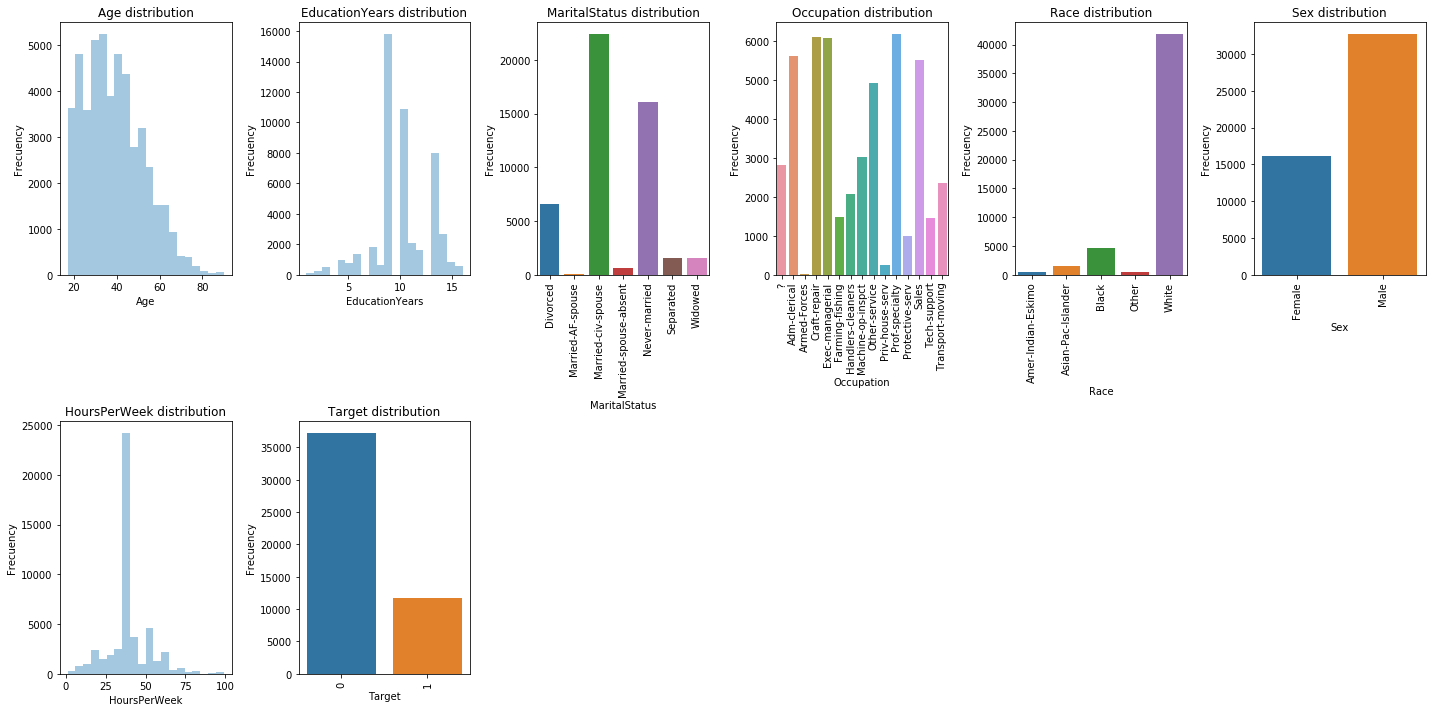

In [35]:
logger.info('Plot data distributions')
plot_distributions(df_classification, n_cols = 6)
plt.show()

and a naive plot of direct dependences

2020-06-10 19:51:47,874 : INFO Plot data targetplots


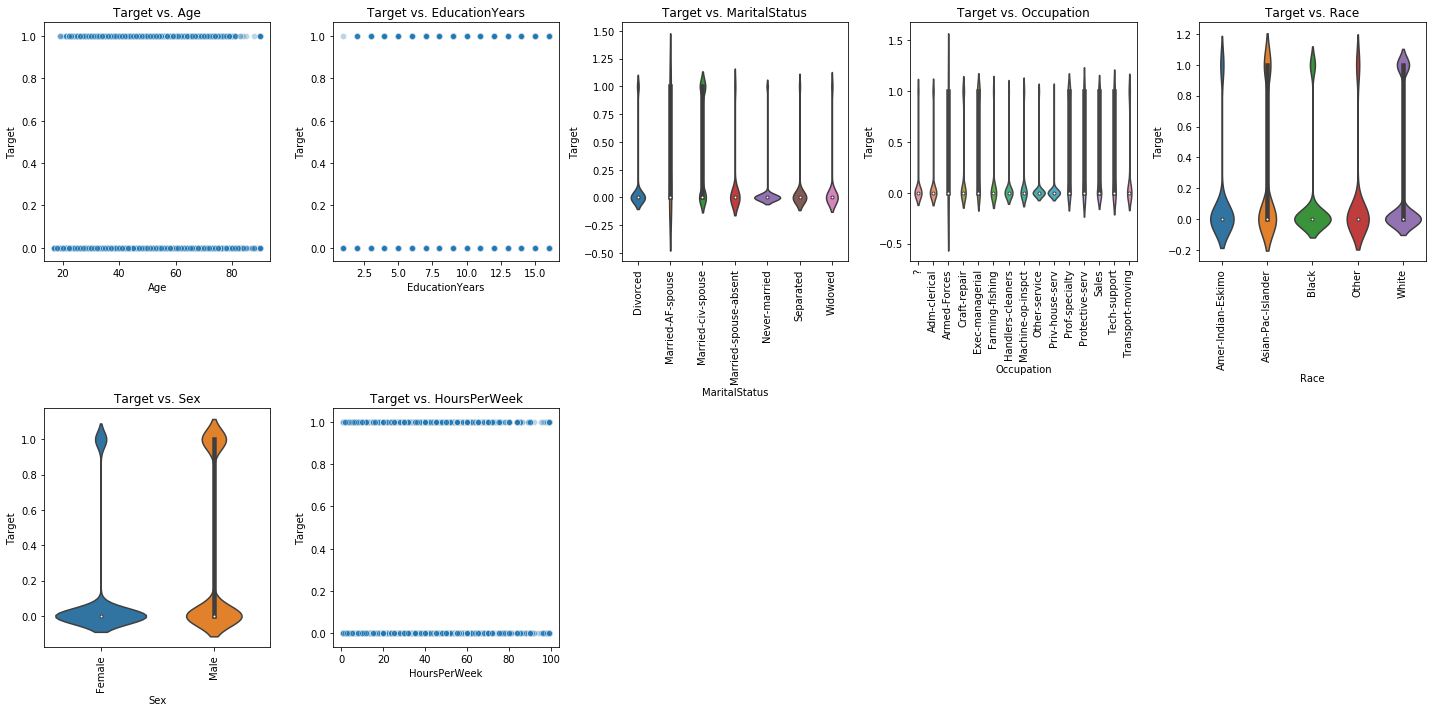

In [36]:
logger.info('Plot data targetplots')
plot_vars_vs_target(df_classification)
plt.show()

# Interpretable models

In [37]:
# Prepare the data for the model
X = df_classification.drop('Target', axis = 1).copy()
y = df_classification['Target'].copy()
    
# Save the original features
features = X.columns.tolist()
categorical_features = [var for var in features if X[var].dtype not in ['int64','float64']]   

# Get dummies for categorical variables
for var in categorical_features:
    X_var = pd.get_dummies(X[var], prefix = var, prefix_sep = '_')
    X = X.drop(var, axis = 1)
    X = pd.concat([X, X_var], axis = 1)

# Create a train set and a test set
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y, random_state=0)

## Linear models

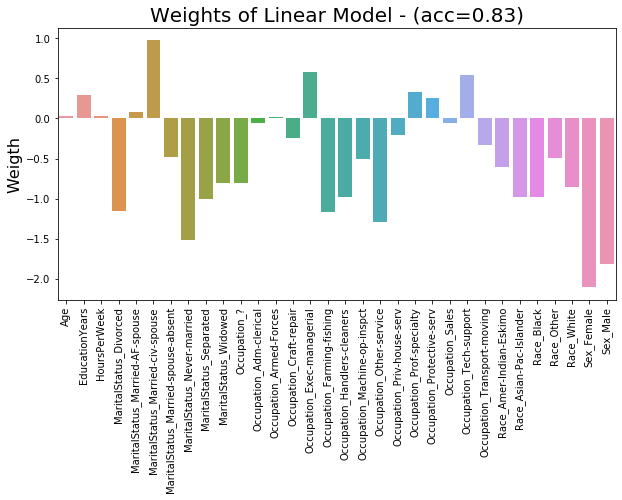

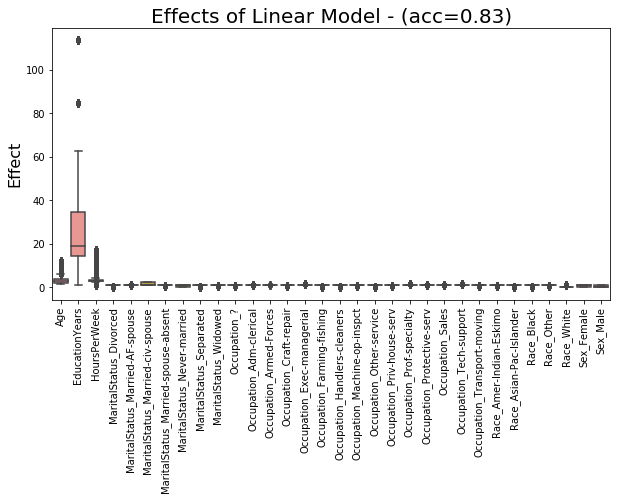

In [38]:
# Initiate and train the model
lr = LogisticRegression()
lr.fit(X_train, y_train)

# Compute weights
df_weights = pd.DataFrame({'Feature' : X.columns, 'Weight' : lr.coef_[0]})

# Compute effects
df_effects = np.exp(np.multiply(X, df_weights.iloc[:,1]))

# Plot weights
plt.figure(figsize = (10, 5))
sns.barplot(x = 'Feature', y = 'Weight', data = df_weights)
plt.title('Weights of Linear Model - (acc={:.2f})'.format(lr.score(X_test, y_test)), fontsize = 20)
plt.xlabel('')
plt.ylabel('Weigth', fontsize = 16)
plt.xticks(rotation = 90)
plt.show()

# Plot effects
plt.figure(figsize = (10, 5))
sns.boxplot(data = df_effects)
plt.title('Effects of Linear Model - (acc={:.2f})'.format(lr.score(X_test, y_test)), fontsize = 20)
plt.xlabel('', fontsize = 16)
plt.ylabel('Effect', fontsize = 16)
plt.xticks(rotation = 90)
plt.show()

## Tree models

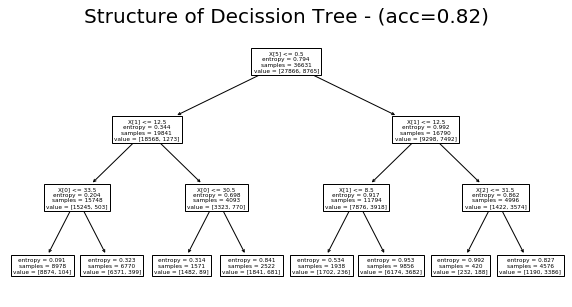

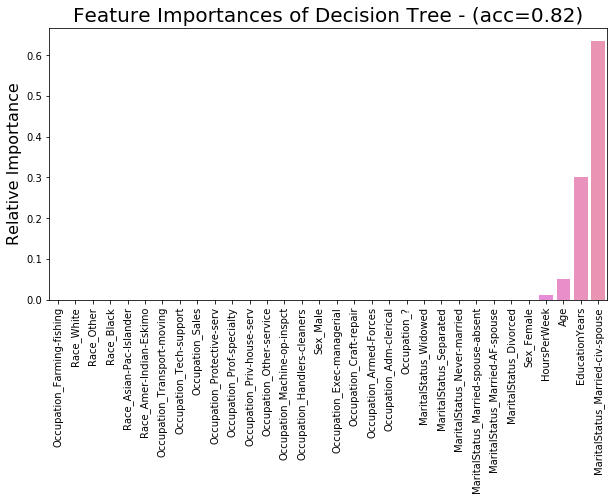

In [39]:
# Initiate and train the model
dtr = DecisionTreeClassifier(max_depth = 3, criterion='entropy')
dtr.fit(X_train, y_train)

# Compute importances
df_importances = pd.DataFrame({'Feature' : X.columns, 'Importance' : dtr.feature_importances_})
df_importances = df_importances.sort_values(by = 'Importance')

# Plot structure
plt.figure(figsize = (10, 5))
plot_tree(dtr)
plt.title('Structure of Decission Tree - (acc={:.2f})'.format(dtr.score(X_test, y_test)), fontsize = 20)
plt.show()

# Plot importances
plt.figure(figsize = (10, 5))
sns.barplot(x = 'Feature', y = 'Importance', data = df_importances)
plt.title('Feature Importances of Decision Tree - (acc={:.2f})'.format(dtr.score(X_test, y_test)), fontsize = 20)
plt.xlabel('', fontsize = 16)
plt.ylabel('Relative Importance', fontsize = 16)
plt.xticks(rotation = 90)
plt.show()

# Non-interpretable models

## Ranfom Forest

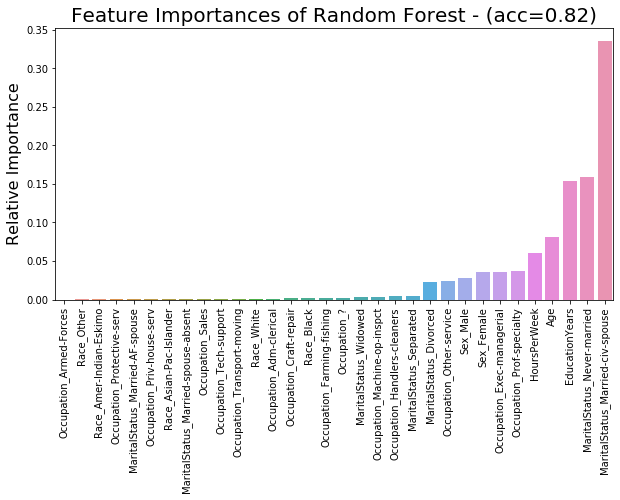

In [40]:
# Initiate and train the model
rfc = RandomForestClassifier(n_estimators = 100, max_depth = 5, criterion = 'entropy')
rfc.fit(X_train, y_train)

# Compute importances
df_importances = pd.DataFrame({'Feature' : X.columns, 'Importance' : rfc.feature_importances_})
df_importances = df_importances.sort_values(by = 'Importance')

# Plot importances
plt.figure(figsize = (10, 5))
sns.barplot(x = 'Feature', y = 'Importance', data = df_importances)
plt.title('Feature Importances of Random Forest - (acc={:.2f})'.format(rfc.score(X_test, y_test)), fontsize = 20)
plt.xlabel('', fontsize = 16)
plt.ylabel('Relative Importance', fontsize = 16)
plt.xticks(rotation = 90)
plt.show()

# Model-Agnostic Methods

## Partial Dependence Plots (PDP)

As we have studied, viewing plots (PDP) of the partial dependence approximations fo the model on selected variables can help to provide a qualitative description of its properties. The algorithm to perfom these plots is the following:  
* Discretize $X_S$ for a smooth interpretation. 
* Compute the predictions of the model $f(x_S,x_C)$ por all $x_S \in X_S, x_C \in X_C$.   
* For a given $x_S \in X_S$ average the predictions over all $x_C \in X_C$.  
* Plot the averaged values vs $X_S$.

### From scratch

In [14]:
def partial_dependence_plot(data, model, var_s, var_target = 'Target', dict_labels = None, n_grid = 10):
    '''
    Compute the partial dependence plot (PDP) of the output of a model with respect to one variable. 
    This computation is made by averaging the target variables over some selected variables, that is, 
    we select the features to keep and use as explanations, make predictions using these points, 
    and average the predictions over the unique values of the selected features.
    
    Args:
        data: pd.DataFrame, dataframe containing the training data of the model
        model: sklearn model instance, model trained with data in data
        var_s: string, name of the variable to compute the partial dependence of
        var_target: string, name of the target variable
        dict_labels: dictionary, dictionary of dictionaries with the labels of the categories for each
        categorical variable
        n_grid: integer, number of points in the PDP
    '''
    logger.info('Compute PDP for {}'.format(var_s))
    
    # Get features
    df = data.copy()
    features_with_dummies = df.columns.tolist()
    
    # Check if var_s is numeric or categorical by looking at the possible dummy variables
    numeric = True
    if var_s not in features_with_dummies:
        var_s_categories = [var for var in features_with_dummies if var_s in var]
        if len(var_s_categories) > 0:
            numeric = False
        else:
            print('This variable is not available.')
            pass
            
    # Make the grid
    logger.debug('* Making the grid')
    if numeric:
        # Discretize the variable in quantiles
        df[var_s] = [(x.left + x.right) / 2 for x in pd.qcut(df[var_s], n_grid)]

        # Get the unique values
        x_s = pd.DataFrame({var_s : df[var_s].unique(), 'key' : 0})

        # Remove the original values
        df = df.drop(var_s, axis = 1)
    else:
        # If the variable is categorical we need to get dummy version of all possible cases
        x_s = pd.DataFrame(np.identity(n = len(var_s_categories)), columns = var_s_categories)
        x_s['key'] = 0
        
        # Remove the original values
        df = df.drop(var_s_categories, axis = 1)
    
    # Make a cartesian product
    df['key'] = 0
    df = x_s.merge(df, on = 'key', how = 'left')
    df = df.drop('key', axis = 1)
    df = df[data.columns.tolist()]
        
    # Index each x_S
    df['Index'] = np.repeat(range(x_s.shape[0]), data.shape[0])
    
    # Make predictions
    logger.debug('* Making predictions')
    df['pred'] = model.predict(df.drop('Index', axis = 1).values)
    y_min = df['pred'].min()
    y_max = df['pred'].max()

    if not numeric:
        # Combine the dummy variables and recover the original categories for visualization purposes
        df_var_s = df[var_s_categories].idxmax(axis = 1)
        df_var_s = df_var_s.apply(lambda x: x.replace(var_s + '_', ''))           
        df = df.drop(var_s_categories, axis = 1)
        df[var_s] = df_var_s
    
    # Compute partial dependences
    logger.debug('* Computing partial dependences')
    df_pdp = df.groupby(var_s, as_index = False)['pred'].mean()
        
    # Make the plot
    logger.debug('* Making the plot')
    if numeric:
        sns.lineplot(x = var_s, 
                     y = 'pred', 
                     data = df_pdp
                     )
        sns.rugplot(a = data[var_s], 
                    height = 0.05, 
                    axis = 'x', 
                    alpha = 0.1
                    )
    else:
        sns.barplot(x = var_s, 
                    y = 'pred', 
                    data = df_pdp
                    )
        sns.pointplot(x = var_s, 
                      y = 'pred', 
                      data = df_pdp, 
                      color = 'black'
                      )
        plt.xticks(rotation = 45)
    
    # Formatting
    plt.title('PDP for {}'.format(var_s), fontsize = 20)
    plt.xlabel(var_s, fontsize = 16)
    plt.ylabel(var_target, fontsize = 16)
    plt.ylim(y_min, y_max)
        
    logger.debug('* Done')

2020-06-10 19:21:18,187 : INFO Compute PDP for EducationYears
2020-06-10 19:21:18,187 : DEBUG * Making the grid
2020-06-10 19:21:18,405 : DEBUG * Making predictions
2020-06-10 19:21:19,390 : DEBUG * Computing partial dependences
2020-06-10 19:21:19,405 : DEBUG * Making the plot
2020-06-10 19:21:19,640 : DEBUG * Done
2020-06-10 19:21:19,656 : INFO Compute PDP for MaritalStatus
2020-06-10 19:21:19,656 : DEBUG * Making the grid
2020-06-10 19:21:19,812 : DEBUG * Making predictions
2020-06-10 19:21:21,844 : DEBUG * Computing partial dependences
2020-06-10 19:21:21,876 : DEBUG * Making the plot
2020-06-10 19:21:21,923 : DEBUG * Done


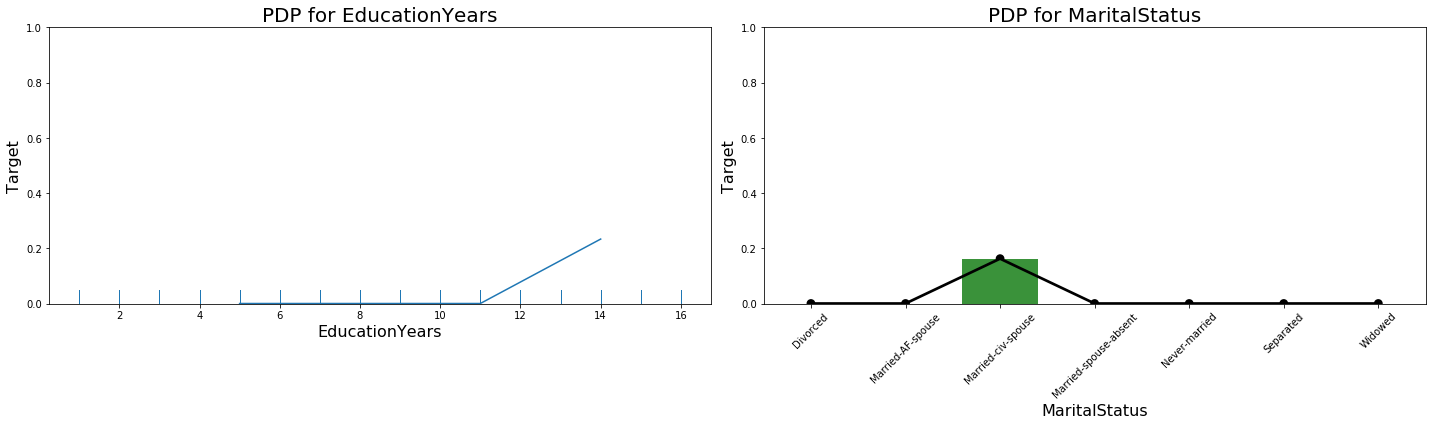

In [15]:
# Obtain the PDPs for variables
features = ['EducationYears', 'MaritalStatus']

# Define the layout of the plot
n_cols = 2
n_rows = len(features) // n_cols + 1

# Obtain PDP for each variable
plt.figure(figsize = (20, 5*n_rows))
for i,var in enumerate(features):
    plt.subplot(n_rows, n_cols, i + 1)
    partial_dependence_plot(data = X_train, 
                            model = rfc, 
                            var_s = var, 
                            var_target = 'Target', 
                            n_grid = 4
                            )
    
plt.tight_layout()
plt.show()

### Extra: pdpbox library

After developing some intuition on PDP building them from scratch, we can explore more advanced implementations of this method. A popular library for this purpose is [PDPbox](https://github.com/SauceCat/PDPbox), it provides more curated visualizations for PDPs and ICEs. We can reproduce some of our examples in its absolute, relative and multifeature form.

2020-06-10 19:21:22,501 : INFO Compute PDP with PDPbox


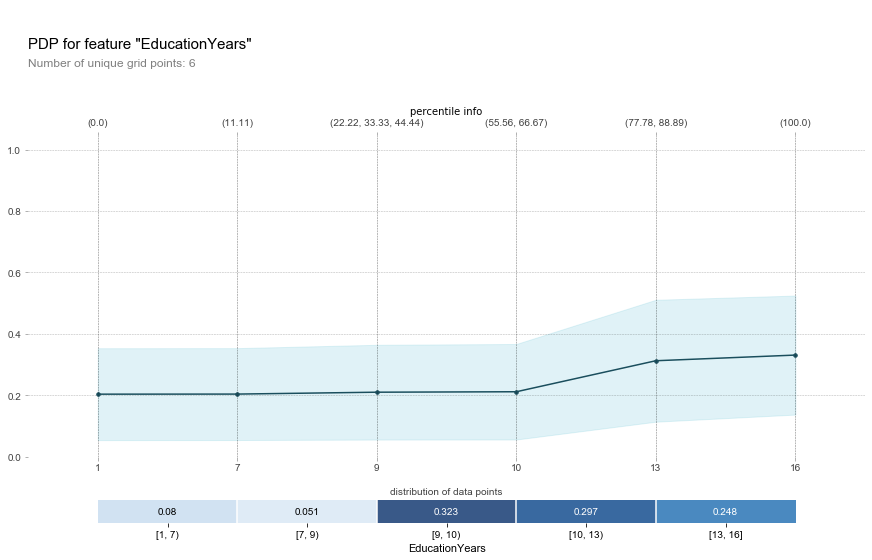

2020-06-10 19:21:24,368 : INFO Compute PDP with PDPbox


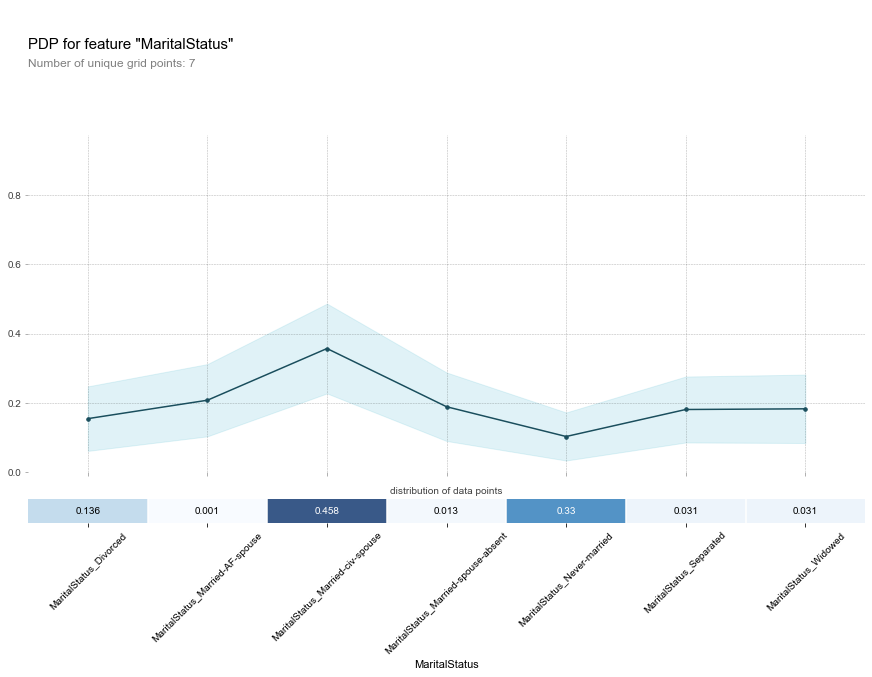

In [16]:
# Numerical variable
logger.info('Compute PDP with PDPbox')
pdp_EducationYears = pdp.pdp_isolate(model = rfc,
                                     dataset = X_train,
                                     model_features = X_train.columns.tolist(),
                                     feature = 'EducationYears'
                                     )
fig, axes = pdp.pdp_plot(pdp_isolate_out = pdp_EducationYears, 
                         feature_name = 'EducationYears', 
                         plot_lines = False, 
                         x_quantile = True, 
                         plot_pts_dist = True, 
                         show_percentile = True, 
                         center = False, 
                         )
plt.show()

# Categorical variable
logger.info('Compute PDP with PDPbox')
pdp_MaritalStatus = pdp.pdp_isolate(model = rfc, 
                             dataset = X_train, 
                             model_features = X_train.columns.tolist(), 
                             feature = [var for var in X_train.columns.tolist() if 'MaritalStatus' in var]
                             )
fig, axes = pdp.pdp_plot(pdp_isolate_out = pdp_MaritalStatus, 
                         feature_name = 'MaritalStatus', 
                         plot_lines = False,
                         plot_pts_dist = True, 
                         center = False
                         )
plt.xticks(rotation=45)
plt.show()

2020-06-10 19:22:34,089 : INFO Compute PDP with PDPbox


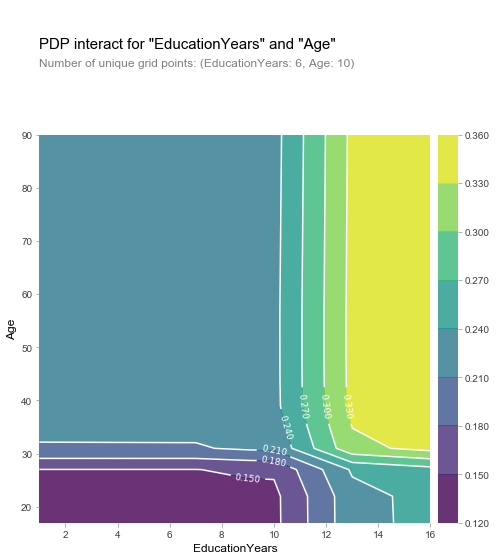

2020-06-10 19:22:50,187 : INFO Compute PDP with PDPbox


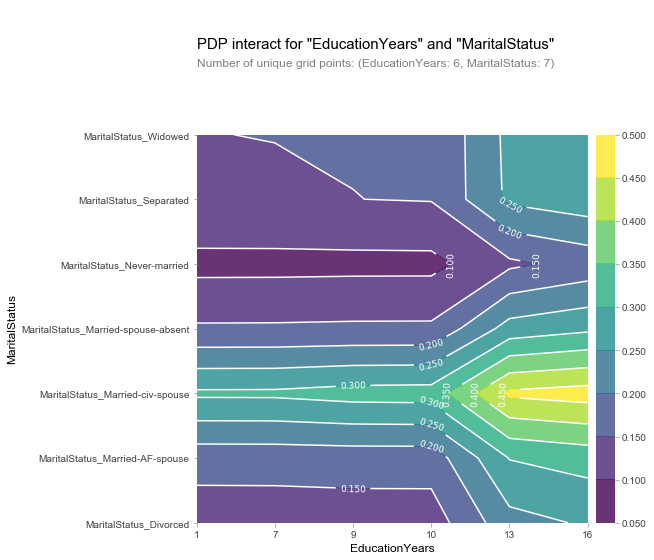

In [18]:
# Numerical variable
logger.info('Compute PDP with PDPbox')
pdp_interaction = pdp.pdp_interact(model = rfc,
                                   dataset = X_train,
                                   model_features = X_train.columns.tolist(),
                                   features = ['EducationYears','Age']
                                   )
fig, axes = pdp.pdp_interact_plot(pdp_interact_out = pdp_interaction,
                                  feature_names = ['EducationYears','Age'],
                                  x_quantile = False,
                                  plot_pdp = False,
                                  plot_type = 'contour'
                                  )
plt.show()

# Categorical variable
logger.info('Compute PDP with PDPbox')
pdp_interaction = pdp.pdp_interact(model = rfc,
                                   dataset = X_train,
                                   model_features = X_train.columns.tolist(),
                                   features = ['EducationYears',[var for var in X_train.columns.tolist() if 'MaritalStatus' in var]]
                                   )
fig, axes = pdp.pdp_interact_plot(pdp_interact_out = pdp_interaction,
                                  feature_names = ['EducationYears','MaritalStatus'],
                                  x_quantile = True,
                                  plot_pdp = False,
                                  plot_type = 'contour'
                                  )
plt.show()

## Independent Conditional Explanation (ICE)

As we have just seen, PDPs show the mean effect of a variable in the predicitions of the model, but we can also look at how individual predictions are affected by the change of this variable. This is knonw as Individual Conditional Explanations. The idea of its calculation is very similar to PDPs:
* Discretize $X_S$ for a smooth interpretation. 
* Compute the predictions of the model $f(x_S,x_C)$ por all $x_S \in X_S, x_C \in X_C$.   
* For each given $x_C \in X_C$ plot the predicictions vs $X_S$.

### From scracth

In [21]:
def independent_conditional_explanation(data, model, var_s, var_target = 'Target', dict_labels = None, n_grid = 10, frac_to_plot = 1.0, centered = False):
    '''
    Compute the independent conditional explanation (ICE) of the output of a model with respect to one 
    variable. This computation is made by averaging the target variables over some selected variables, that is, 
    we select the features to keep and use as explanations, make predictions using these points, 
    and average the predictions over the unique values of the selected features.
    
    Args:
        data: pd.DataFrame, dataframe containing the training data of the model
        model: sklearn model instance, model trained with data in data
        var_s: string, name of the variable to compute the partial dependence of
        var_target: string, name of the target variable
        dict_labels: dictionary, dictionary of dictionaries with the labels of the categories for each
        categorical variable
        n_grid: integer, number of points in the ICE
        frac_to_plot: float, frac of the samples to plot the ICE for
    '''
    logger.info('Compute ICE for {}'.format(var_s))
    
    # Get features
    df = data.copy()
    features_with_dummies = df.columns.tolist()
    
    # Check if var_s is numeric or categorical by looking at the possible dummy variables
    numeric = True
    if var_s not in features_with_dummies:
        var_s_categories = [var for var in features_with_dummies if var_s in var]
        if len(var_s_categories) > 0:
            numeric = False
        else:
            print('This variable is not available.')
            pass
            
    # Make the grid
    logger.debug('* Making the grid')
    if numeric:
        # Discretize the variable in quantiles
        df[var_s] = [(x.left + x.right) / 2 for x in pd.qcut(df[var_s], n_grid)]

        # Get the unique values
        x_s = pd.DataFrame({var_s : df[var_s].unique(), 'key' : 0})

        # Remove the original values
        df = df.drop(var_s, axis = 1)
    else:
        # If the variable is categorical we need to get dummy version of all possible cases
        x_s = pd.DataFrame(np.identity(n = len(var_s_categories)), columns = var_s_categories)
        x_s['key'] = 0
        
        # Remove the original values
        df = df.drop(var_s_categories, axis = 1)
    
    # Make a cartesian product
    df['key'] = 0
    df = df.merge(x_s, on = 'key', how = 'left')
    df = df.drop('key', axis = 1)
    df = df[data.columns.tolist()]
        
    # Index each x_C
    df['Index'] = np.repeat(range(data.shape[0]), x_s.shape[0])
    
    # Make predictions
    logger.debug('* Making predictions')
    df['pred'] = model.predict(df.drop('Index', axis = 1).values)
    y_min = df['pred'].min()
    y_max = df['pred'].max()

    if not numeric:
        # Combine the dummy variables and recover the original categories for visualization purposes
        df_var_s = df[var_s_categories].idxmax(axis = 1)
        df_var_s = df_var_s.apply(lambda x: x.replace(var_s + '_', ''))           
        df = df.drop(var_s_categories, axis = 1)
        df[var_s] = df_var_s
        
    # Center the plot if necessary
    if centered:
        for idx in df['Index'].unique():
            pred_min = df.loc[df['Index'] == idx, 'pred'].min()
            df.loc[df['Index'] == idx, 'pred'] = df.loc[df['Index'] == idx, 'pred'] - pred_min

    # Pepare table for plot if necessary
    if frac_to_plot < 1.:
        idx = df['Index'].max()
        idx = np.random.choice(range(idx), size = int(frac_to_plot * idx), replace = False)
        df = df[df['Index'].isin(idx)]
    
    # Compute partial dependences
    logger.debug('* Computing partial dependences')
    df_pdp = df.groupby(var_s, as_index = False)['pred'].mean()
    
    # Make the plot
    logger.debug('* Making the plot')
    if numeric:
        sns.lineplot(x = var_s, 
                     y = 'pred', 
                     hue = 'Index', 
                     data = df, 
                     alpha = 1, 
                     palette = {i : 'gray' for i in df['Index'].unique()}, 
                     legend = False
                     )
        sns.lineplot(x = var_s, 
                     y = 'pred', 
                     data = df_pdp, 
                     color = 'orange',
                     linewidth = 10
                     )
        sns.rugplot(a = data[var_s], 
                    height = 0.05, 
                    axis = 'x', 
                    alpha = 0.1, 
                    color = 'gray'
                    )
    else:
        sns.pointplot(x = var_s, 
                      y = 'pred', 
                      hue = 'Index', 
                      data = df,
                      alpha = 0.1, 
                      palette = {i : 'gray' for i in df['Index'].unique()}, 
                      markers = {i : False for i in df['Index'].unique()}
                      ).legend_.remove()
        sns.pointplot(x = var_s, 
                      y = 'pred', 
                      data = df_pdp,
                      color = 'orange',
                      scale = 2
                      )
        plt.xticks(rotation = 45)
        
    # Formatting
    if centered:
        plt.title('c-ICE for {}'.format(var_s), fontsize = 20)
    else:
        plt.title('ICE for {}'.format(var_s), fontsize = 20)
    plt.xlabel(var_s, fontsize = 16)
    plt.ylabel(var_target, fontsize = 16)
    plt.ylim(df['pred'].min(), df['pred'].max())

    logger.debug('* Done')

In [ ]:
# Obtain the ICEs for variables
features = ['EducationYears', 'MaritalStatus']

# Define the layout of the plot
n_cols = 2
n_rows = len(features) // n_cols + 1

# Obtain PDP for each variable
plt.figure(figsize = (20, 5*n_rows))
for i,var in enumerate(features):
    plt.subplot(n_rows, n_cols, i + 1)
    independent_conditional_explanation(data = X_train, 
                                        model = rfc, 
                                        var_s = var, 
                                        var_target = 'Target', 
                                        n_grid = 4,
                                        frac_to_plot = 1,
                                        centered = False
                                        )
plt.tight_layout()
plt.show()

In [ ]:
# Obtain the ICEs for variables
features = ['EducationYears', 'MaritalStatus']

# Define the layout of the plot
n_cols = 2
n_rows = len(features) // n_cols + 1

# Obtain PDP for each variable
plt.figure(figsize = (20, 5*n_rows))
for i,var in enumerate(features):
    plt.subplot(n_rows, n_cols, i + 1)
    independent_conditional_explanation(data = X_train, 
                                        model = rfc, 
                                        var_s = var, 
                                        var_target = 'Target', 
                                        n_grid = 4,
                                        frac_to_plot = 1,
                                        centered = True
                                        )
plt.tight_layout()
plt.show()

### Extra: pdpbox library

In [27]:
# Numerical variable
logger.info('Compute ICE with PDPbox')
pdp_EducationYears = pdp.pdp_isolate(model = rfc,
                                  dataset = X_train,
                                  model_features = X_train.columns.tolist(),
                                  feature = 'EducationYears'
                                  )
fig, axes = pdp.pdp_plot(pdp_isolate_out = pdp_EducationYears, 
                         feature_name = 'EducationYears', 
                         plot_lines = True, 
                         x_quantile = True, 
                         plot_pts_dist = True, 
                         show_percentile = True, 
                         center = False
                         )
plt.show()

# Categorical variable
logger.info('Compute ICE with PDPbox')
pdp_MaritalStatus = pdp.pdp_isolate(model = rfc, 
                             dataset = X_train, 
                             model_features = X_train.columns.tolist(), 
                             feature = [var for var in X_train.columns.tolist() if 'MaritalStatus' in var]
                             )
fig, axes = pdp.pdp_plot(pdp_isolate_out = pdp_MaritalStatus, 
                         feature_name = 'MaritalStatus', 
                         plot_lines = True,
                         plot_pts_dist = True, 
                         center = False
                         )
plt.show()

2020-06-10 19:40:11,641 : INFO Compute ICE with PDPbox


KeyboardInterrupt: 

Error in callback <function flush_figures at 0x0000026FE1A1CD90> (for post_execute):


KeyboardInterrupt: 

2020-06-03 15:54:42,429 : INFO Compute ICE with PDPbox


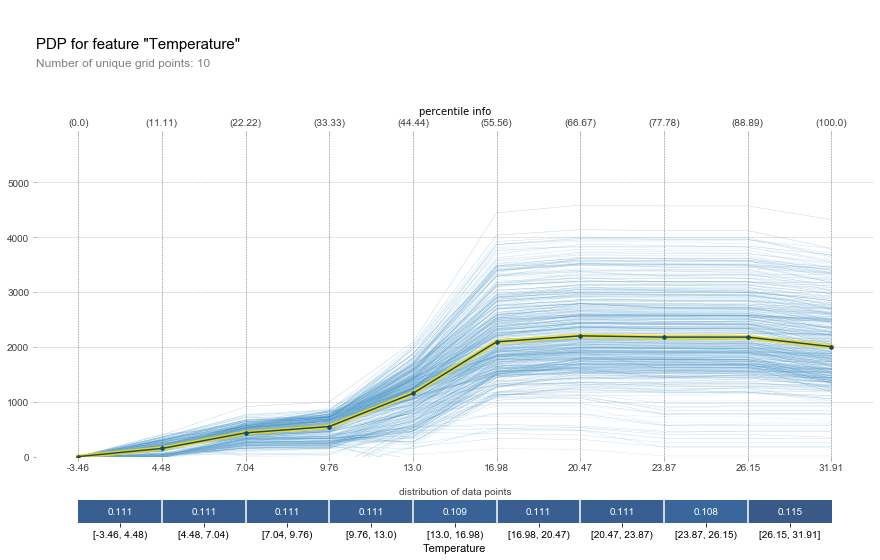

2020-06-03 15:54:44,050 : INFO Compute ICE with PDPbox


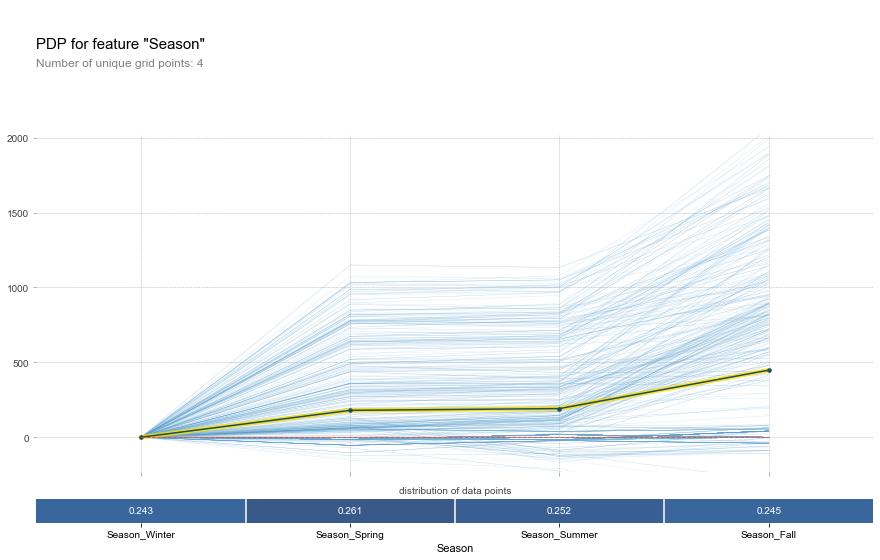

In [22]:
# Numerical variable
logger.info('Compute ICE with PDPbox')
fig, axes = pdp.pdp_plot(pdp_isolate_out = pdp_Temperature, 
                                feature_name = 'EducationYears', 
                                plot_lines = True, 
                                x_quantile = True, 
                                plot_pts_dist = True, 
                                show_percentile = True, 
                                center = True
                                )
plt.show()

# Categorical variable
logger.info('Compute ICE with PDPbox')
fig, axes = pdp.pdp_plot(pdp_isolate_out = pdp_Season, 
                         feature_name = 'MaritalStatus', 
                         plot_lines = True,
                         plot_pts_dist = True, 
                         center = True
                         )
plt.show()

## Accumulated Local Effects (ALE)

In the process of computing PDPs and ICEs we have seen that we have to create data points following the marginal distribution of each variable, but this can lead to points that have no sense when considering the joint distribution of all variables. One way to avoid this is with A

### From scratch

In [23]:
def marginal_plot(data, model, var_s, var_target = 'Target', dict_labels = None, n_grid = 10):
    '''
    Compute the marginal plot of the output of a model with respect to one variable.
    
    Args:
        data: pd.DataFrame, dataframe containing the training data of the model
        model: sklearn model instance, model trained with data in data
        var_s: string, name of the variable to compute the partial dependence of
        var_target: string, name of the target variable
        dict_labels: dictionary, dictionary of dictionaries with the labels of the categories for each
        categorical variable
        n_grid: integer, number of points in the PDP
    '''
    logger.info('Compute MP for {}'.format(var_s))
    
    # Get features
    df = data.copy()
    features_with_dummies = df.columns.tolist()
    
    # Check if var_s is numeric or categorical by looking at the possible dummy variables
    numeric = True
    if var_s not in features_with_dummies:
        var_s_categories = [var for var in features_with_dummies if var_s in var]
        if len(var_s_categories) > 0:
            numeric = False
        else:
            print('This variable is not available.')
            pass
    
    # Make predictions
    logger.debug('* Making predictions')
    df['pred'] = model.predict(df.values)
    y_min = df['pred'].min()
    y_max = df['pred'].max()

    if numeric:
        # Make quantile of the variable
        df[var_s] = [(x.left + x.right) / 2 for x in pd.qcut(df[var_s], n_grid)]
    else:
        # Combine the dummy variables and recover the original categories for visualization purposes
        df_var_s = df[var_s_categories].idxmax(axis = 1)
        df_var_s = df_var_s.apply(lambda x: x.replace(var_s + '_', ''))           
        df = df.drop(var_s_categories, axis = 1)
        df[var_s] = df_var_s
    
    # Compute partial dependences
    logger.debug('* Computing marginal dependences')
    df_pdp = df.groupby(var_s, as_index = False)['pred'].mean()
        
    # Make the plot
    logger.debug('* Making the plot')
    if numeric:
        sns.lineplot(x = var_s, 
                     y = 'pred', 
                     data = df_pdp
                     )
        sns.rugplot(a = data[var_s], 
                    height = 0.05, 
                    axis = 'x', 
                    alpha = 0.1
                    )
    else:
        sns.barplot(x = var_s, 
                    y = 'pred', 
                    order = dict_labels[var_s].values(), 
                    data = df_pdp
                    )
        sns.pointplot(x = var_s, 
                      y = 'pred', 
                      order = dict_labels[var_s].values(), 
                      data = df_pdp, 
                      color = 'black'
                      )
        plt.xticks(rotation = 45)
    
    # Formatting
    plt.title('MP for {}'.format(var_s), fontsize = 20)
    plt.xlabel(var_s, fontsize = 16)
    plt.ylabel(var_target, fontsize = 16)
    plt.ylim(y_min, y_max)
        
    logger.debug('* Done')

2020-06-03 15:54:45,604 : INFO Compute MP for Temperature
2020-06-03 15:54:45,605 : DEBUG * Making predictions
2020-06-03 15:54:45,614 : DEBUG * Computing marginal dependences
2020-06-03 15:54:45,617 : DEBUG * Making the plot
2020-06-03 15:54:45,646 : DEBUG * Done
2020-06-03 15:54:45,654 : INFO Compute MP for Season
2020-06-03 15:54:45,655 : DEBUG * Making predictions
2020-06-03 15:54:45,663 : DEBUG * Computing marginal dependences
2020-06-03 15:54:45,666 : DEBUG * Making the plot
2020-06-03 15:54:45,689 : DEBUG * Done


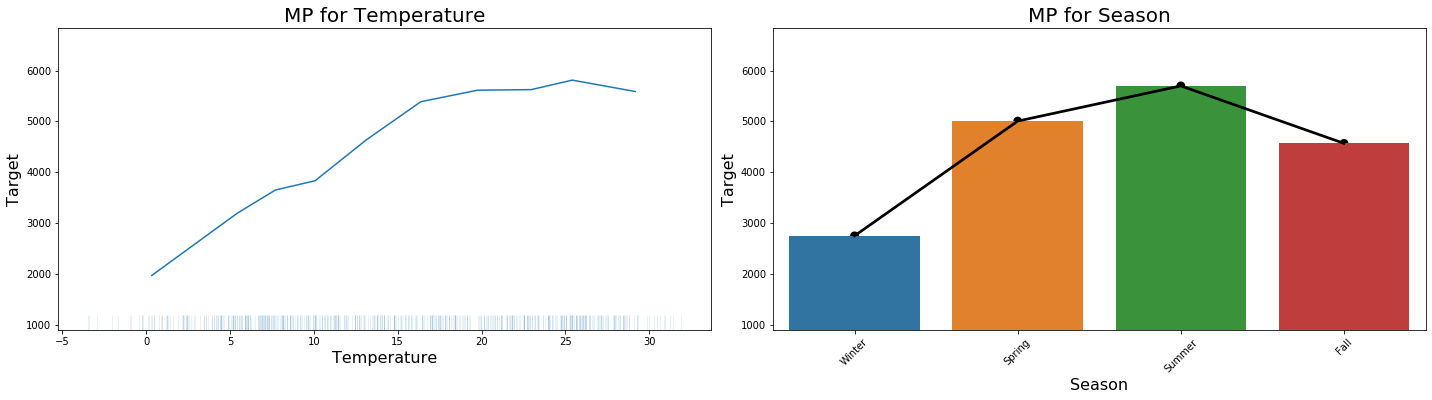

In [24]:
# Obtain the PDPs for variables
features = ['Temperature', 'Season']

# Define the layout of the plot
n_cols = 2
n_rows = len(features) // n_cols + 1

# Obtain PDP for each variable
plt.figure(figsize = (20, 5*n_rows))
for i,var in enumerate(features):
    plt.subplot(n_rows, n_cols, i + 1)
    marginal_plot(data = X_train, 
                            model = rfc, 
                            var_s = var, 
                            var_target = 'Target', 
                            dict_labels = dict_labels,
                            n_grid = 10
                            )
plt.tight_layout()
plt.show()

### Extra: alepython library

2020-06-03 15:54:45,937 : INFO Compute ALE with ALEpython


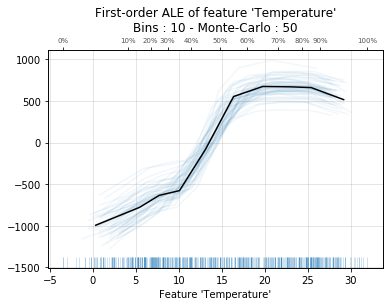

2020-06-03 15:54:46,936 : INFO Compute ALE with ALEpython


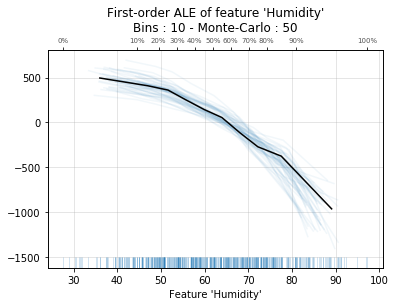

In [25]:
# Numerical variable
logger.info('Compute ALE with ALEpython')
ale_plot(model = rfc, 
         train_set = X_train, 
         features = 'Temperature', 
         bins = 10,
         monte_carlo = True
         )

logger.info('Compute ALE with ALEpython')
ale_plot(model = rfc, 
         train_set = X_train, 
         features = 'Humidity', 
         bins = 10,
         monte_carlo = True
         )

# Categorical variable: NOT IMPLEMENTED YET
# logger.info('Compute ALE with ALEpython')
# ale_plot(model = rfr, 
#          train_set = X_train, 
#          features = 'Season',
#          features_classes = ['Season_Winter','Season_Spring','Season_Summer','Season_Fall']
#          )

2020-06-03 15:54:47,912 : INFO Compute ALE with ALEpython


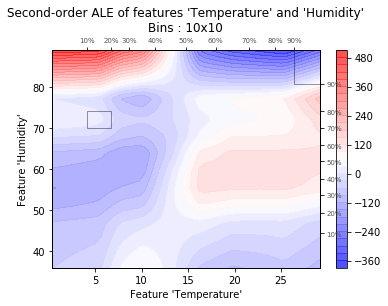

In [26]:
# Numerical variable
logger.info('Compute ALE with ALEpython')
ale_plot(model = rfc, 
         train_set = X_train, 
         features = ['Temperature','Humidity'], 
         bins = 10,
         monte_carlo = True
         )

# Categorical variable: NOT IMPLEMENTED YET
# logger.info('Compute ALE with ALEpython')
# ale_plot(model = rfc, 
#          train_set = X_train, 
#          features = 'Season',
#          features_classes = ['Season_Winter','Season_Spring','Season_Summer','Season_Fall']
#          )

## Permutation Feature Importance

### From scratch

### Extra: sklearn

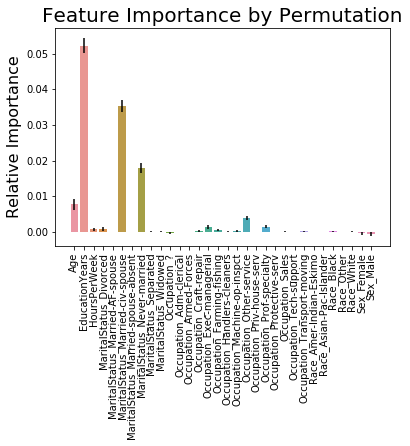

In [42]:
# Compute FPI
pfi = permutation_importance(rfc, 
                             X_test, 
                             y_test,
                             n_repeats = 10,
                             random_state = 0
                             )

# Prepare dataframe 
df_pfi = pd.DataFrame({'Feature'          : X_test.columns, 
                       'importances_mean' : pfi['importances_mean'],
                       'importances_std'  : pfi['importances_std']
                       })

# Make the plot
sns.barplot(x = 'Feature', y = 'importances_mean', data = df_pfi)
plt.errorbar(x = df_pfi['Feature'], 
             y = df_pfi['importances_mean'], 
             yerr = df_pfi['importances_std'],
             color = 'black', 
             linestyle = ''
             )
plt.title('Feature Importance by Permutation', fontsize = 20)
plt.xlabel('')
plt.ylabel('Relative Importance', fontsize = 16)
plt.xticks(rotation = 90)
plt.show()

### Extra: eli5

This library includes a module for computing FPI for sklearn models. This module generates this values using the function *PermutationImportance*, which needs the following arguments:
* *estimator* (object): The base estimator. This can be both a fitted (if prefit is set to True) or a non-fitted estimator.
* *scoring* (string, callable or None, default=None): Scoring function to use for computing feature importances. A string with scoring name (see scikit-learn docs) or a scorer callable object / function with signature scorer(estimator, X, y). If None, the score method of the estimator is used.
* *n_iter* (int, default 5): Number of random shuffle iterations. Decrease to improve speed, increase to get more precise estimates.

In [51]:
# Compute FPI
perm = eli5.sklearn.PermutationImportance(rfc, n_iter = 10, random_state=0)
perm = perm.fit(X_test, y_test)

# Make the plots
eli5.show_weights(perm, feature_names = X_test.columns.tolist())

## Shapley values

### From scratch

### Extra: shap library

This library includes a modules for computing SHAP for various models: 
* *TreeExplainer*: An implementation of Tree SHAP, a fast and exact algorithm to compute SHAP values for trees and ensembles of trees.
* *DeepExplainer*: An implementation of Deep SHAP, a faster (but only approximate) algorithm to compute SHAP values for deep learning models that is based on connections between SHAP and the DeepLIFT algorithm.
* *GradientExplainer*: An implementation of expected gradients to approximate SHAP values for deep learning models. It is based on connections between SHAP and the Integrated Gradients algorithm. GradientExplainer is slower than DeepExplainer and makes different approximation assumptions.
* *LinearExplainer*: For a linear model with independent features we can analytically compute the exact SHAP values. We can also account for feature correlation if we are willing to estimate the feature covaraince matrix. LinearExplainer supports both of these options.
* *KernelExplainer*: An implementation of Kernel SHAP, a model agnostic method to estimate SHAP values for any model. Because it makes not assumptions about the model type, KernelExplainer is slower than the other model type specific algorithms.

We are using *KernelExplainer* by its model-agnosticness. It has the following arguments:
* *model*: function or iml.Model. User supplied function that takes a matrix of samples (# samples x # features) and computes a the output of the model for those samples. The output can be a vector (# samples) or a matrix (# samples x # model outputs).
* *data*: numpy.array or pandas.DataFrame or shap.common.DenseData or any scipy.sparse matrix The background dataset to use for integrating out features. To determine the impact of a feature, that feature is set to “missing” and the change in the model output is observed. Since most models aren’t designed to handle arbitrary missing data at test time, we simulate “missing” by replacing the feature with the values it takes in the background dataset. So if the background dataset is a simple sample of all zeros, then we would approximate a feature being missing by setting it to zero. For small problems this background dataset can be the whole training set, but for larger problems consider using a single reference value or using the kmeans function to summarize the dataset. Note: for sparse case we accept any sparse matrix but convert to lil format for performance.
* *link*:“identity” or “logit”. A generalized linear model link to connect the feature importance values to the model output. Since the feature importance values, phi, sum up to the model output, it often makes sense to connect them to the output with a link function where link(output) = sum(phi). If the model output is a probability then the LogitLink link function makes the feature importance values have log-odds units.

And we can get many different plots:
* *force_plot()*: plots the Shapley values, the effects of each feature's value on the prediction, for each instance.
* *summary_plot()*: plot the distribution Shapley values for all instances in a violin plot.
* *dependence_plot()*: plot the distribution Shapley values of a feature respect to the value of the feature.
* *waterfall_plot()*: plot the values on force_plot more clear.

In [53]:
# Initialize JS for plots
shap.initjs()

# Create explainer
explainer = shap.KernelExplainer(model = rfc.predict, 
                                 data = np.array(X_train)
                                 )

# Predict for many instances
shap_values = explainer.shap_values(X_test, nsamples = 10)

Using 36631 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


KeyboardInterrupt: 

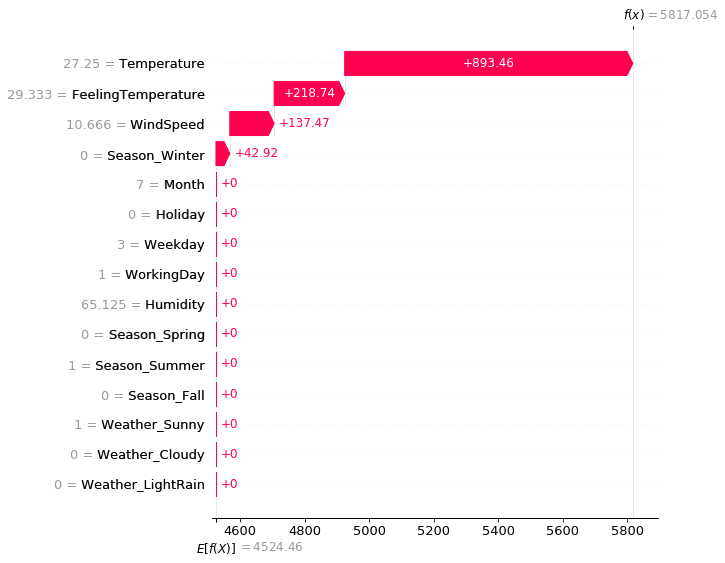

In [114]:
# Predict for single instances
i = 1
shap.waterfall_plot(explainer.expected_value, shap_values[i], X_test.iloc[i,:], max_display = 20)

In [115]:
shap.force_plot(explainer.expected_value, shap_values[i], X_test.iloc[i,:])

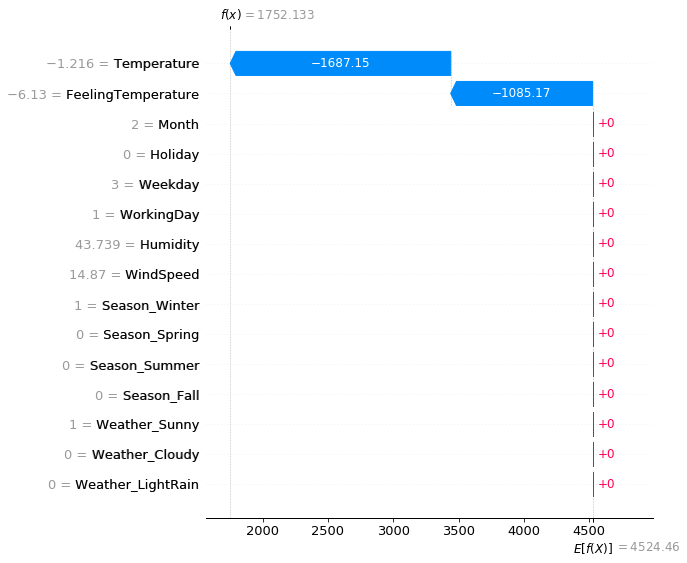

In [116]:
# Predict for single instances
i = 10
shap.waterfall_plot(explainer.expected_value, shap_values[i], X_test.iloc[i,:], max_display = 20)

In [117]:
shap.force_plot(explainer.expected_value, shap_values[i], X_test.iloc[i,:])

In [118]:
# Predict for many instances
shap.force_plot(explainer.expected_value, shap_values[1:10,:], X_test.iloc[1:10,:])

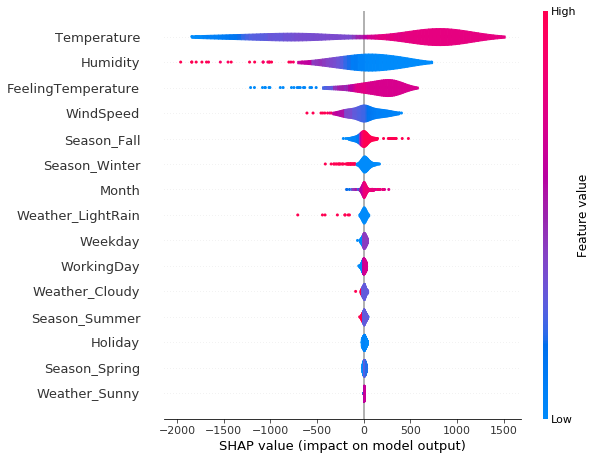

In [119]:
# Get summary plot
shap.summary_plot(shap_values, 
                  X_test, 
                  feature_names = X.columns.tolist(),
                  plot_type="violin"
                  )

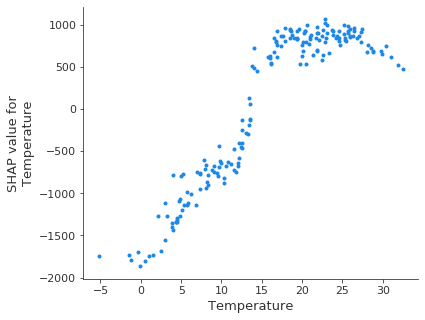

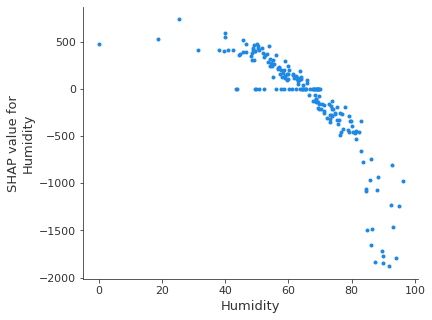

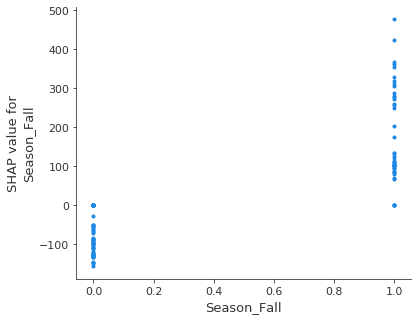

In [97]:
# Get some dependence plots
for i, var in enumerate(['Temperature','Humidity','Season_Fall']):
    shap.dependence_plot(var, shap_values, X_test, feature_names = X_test.columns, interaction_index = None)

## Global Surrogate Models

In [27]:
def surrogate_model_linear(model, X_train, X_test):
    # Get predictions from the original model
    y_train = model.predict(X_train)
    y_test  = model.predict(X_test)
    
    # Initiate and train the linear model
    lr = LinearRegression()
    lr.fit(X_train, y_train)
    
    # Compute weights
    df_weights = pd.DataFrame({'Feature' : X_train.columns, 'Weight' : lr.coef_})

    # Compute effects
    df_effects = np.multiply(X, df_weights.iloc[:,1])

    # Plot weights
    plt.figure(figsize = (10, 5))
    sns.barplot(x = 'Feature', y = 'Weight', data = df_weights)
    plt.title('Weights of Linear Model - ($R^2$={:.2f})'.format(lr.score(X_test, y_test)), fontsize = 20)
    plt.xlabel('')
    plt.ylabel('Weigth', fontsize = 16)
    plt.xticks(rotation = 90)
    plt.show()

    # Plot effects
    plt.figure(figsize = (10, 5))
    sns.boxplot(data = df_effects)
    plt.title('Effects of Linear Model - ($R^2$={:.2f})'.format(lr.score(X_test, y_test)), fontsize = 20)
    plt.xlabel('', fontsize = 16)
    plt.ylabel('Effect', fontsize = 16)
    plt.xticks(rotation = 90)
    plt.show()

In [28]:
def surrogate_model_tree(model, X_train, X_test):
    # Get predictions from the original model
    y_train = model.predict(X_train)
    y_test  = model.predict(X_test)
    
    # Initiate and train the model
    dtr = DecisionTreeRegressor(max_depth = 3)
    dtr.fit(X_train, y_train)

    # Compute importances
    df_importances = pd.DataFrame({'Feature' : X.columns, 'Importance' : dtr.feature_importances_})
    df_importances = df_importances.sort_values(by = 'Importance')

    # Plot structure
    plt.figure(figsize = (10, 5))
    plot_tree(dtr)
    plt.title('Structure of Decission Tree - ($R^2$={:.2f})'.format(dtr.score(X_test, y_test)), fontsize = 20)
    plt.show()

    # Plot importances
    plt.figure(figsize = (10, 5))
    sns.barplot(x = 'Feature', y = 'Importance', data = df_importances)
    plt.title('Feature Importances of Decision Tree - ($R^2$={:.2f})'.format(dtr.score(X_test, y_test)), fontsize = 20)
    plt.xlabel('', fontsize = 16)
    plt.ylabel('Relative Importance', fontsize = 16)
    plt.xticks(rotation = 90)
    plt.show()

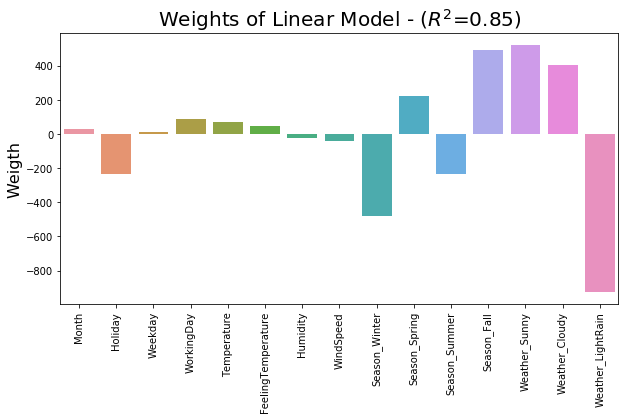

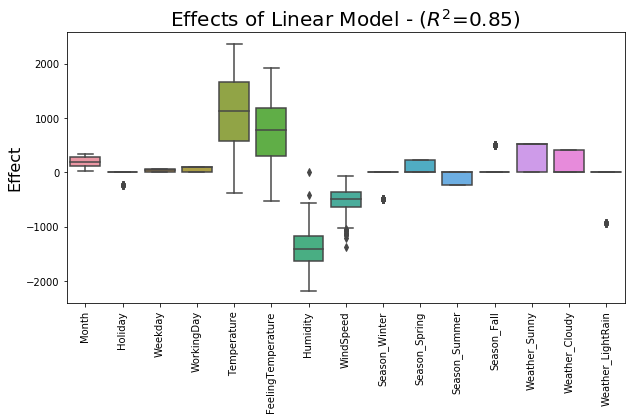

In [29]:
surrogate_model_linear(rfc, X_train, X_test)

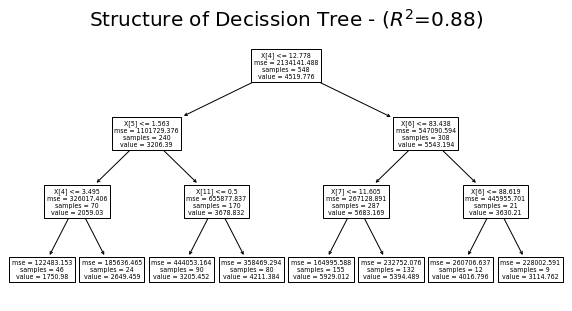

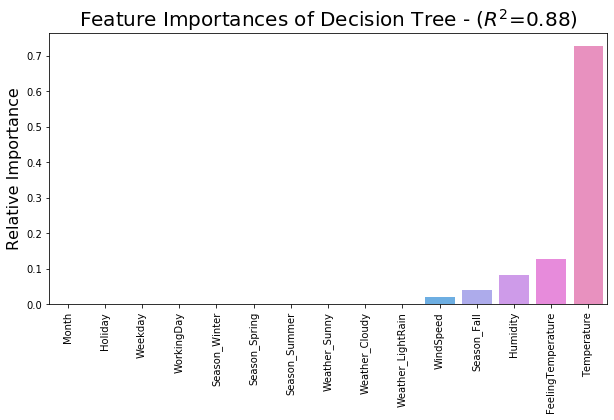

In [30]:
surrogate_model_tree(rfc, X_train, X_test)

## LIME

### From scratch

### Extra: lime library

In [68]:
# Get feature names
feature_names = X.columns.tolist()
categorical_features = [i for i, col in enumerate(X_train.columns) if ('_' in col)]

# Create explainer
explainer = LimeTabularExplainer(np.array(X_train), 
                                 feature_names = feature_names, 
                                 class_names = ['Target'], 
                                 categorical_features = categorical_features, 
                                 verbose = True, 
                                 mode = 'regression')

# Explain some instance prediction
for i in [1,10]:
    exp = explainer.explain_instance(np.array(X_test)[i], rfc.predict, num_features=5)
    exp.show_in_notebook(show_table = True)
    htmlaa = exp.as_html()
    for x in exp.as_list():
        print(x)

Intercept 4277.554207417803
Prediction_local [5687.02786263]
Right: 5817.054461855447


('Temperature > 22.83', 1114.3542206608824)
('Season_Fall=0', -305.69664881575454)
('FeelingTemperature > 24.23', 290.48897520964874)
('Season_Winter=0', 202.88180575586546)
('8.92 < WindSpeed <= 12.13', 107.4453024020065)
Intercept 5285.378672959122
Prediction_local [3115.60285593]
Right: 1752.1325917633023


('Temperature <= 7.54', -1521.4243466607652)
('FeelingTemperature <= 5.85', -763.6580205093227)
('Humidity <= 50.88', 628.2223527960062)
('Season_Fall=0', -330.37217487518416)
('Season_Winter=1', -182.5436277809557)
